In [ ]:
import torch




import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchsummary import summary

# import tensorflow as tf
# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # 忽略低级别的警告
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# # The GPU id to use, usually either "0" or "1"
# os.environ["CUDA_VISIBLE_DEVICES"]="0"
# config = tf.compat.v1.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.9
# # config.gpu_options.allow_growth = True
# session = tf.compat.v1.Session(config=config)





In [ ]:
transform = transforms.Compose([
#     transforms.CenterCrop(224),
    transforms.RandomCrop(32,padding=4), # 数据增广
    transforms.RandomHorizontalFlip(),  # 数据增广
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]) 

In [ ]:
Batch_Size = 256

In [ ]:
trainset = datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
testset = datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=Batch_Size,shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=Batch_Size,shuffle=True, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
classes = trainset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
trainset.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [ ]:
trainset.data.shape #50000是图片数量，32x32是图片大小，3是通道数量RGB

(50000, 32, 32, 3)

In [ ]:
#查看数据类型
print(type(trainset.data))
print(type(trainset))

<class 'numpy.ndarray'>
<class 'torchvision.datasets.cifar.CIFAR10'>


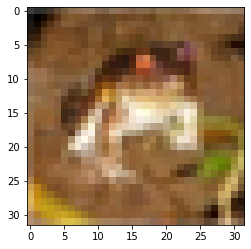

In [ ]:
# check images
import numpy as np
import matplotlib.pyplot as plt
plt.imshow(trainset.data[0])
im,label = iter(trainloader).next()

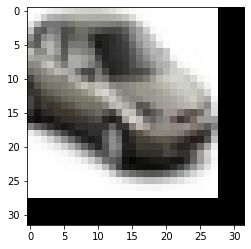

In [ ]:
def imshow(img):
    img = img / 2 + 0.5
    img = np.transpose(img.numpy(),(1,2,0))
    plt.imshow(img)

imshow(im[0])

In [ ]:
im[0].shape

torch.Size([3, 32, 32])

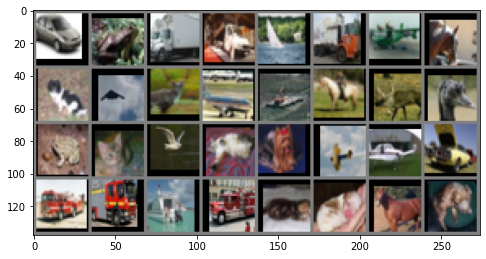

In [ ]:
plt.figure(figsize=(8,12))
imshow(torchvision.utils.make_grid(im[:32]))

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self,in_channels,out_channels,stride=1):
        super(Block,self).__init__()
        # groups参数就是深度可分离卷积的关键
        self.conv1 = nn.Conv2d(in_channels,in_channels,kernel_size=3,stride=stride,
                               padding=1,groups=in_channels,bias=False)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=1,padding=0,bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU()
    def forward(self,x):
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.relu2(self.bn2(self.conv2(x)))
        return x
        
# 深度可分离卷积 DepthWise Separable Convolution
class MobileNetV1(nn.Module):
    # (128,2) means conv channel=128, conv stride=2, by default conv stride=1
    cfg = [64,(128,2),128,(256,2),256,(512,2),512,512,512,512,512,(1024,2),1024]
    
    def __init__(self, num_classes=10,alpha=1.0,beta=1.0):
        super(MobileNetV1,self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3,32,kernel_size=3,stride=1,bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.avg = nn.AvgPool2d(kernel_size=2)
        self.layers = self._make_layers(in_channels=32)
        self.linear = nn.Linear(1024,num_classes)
    
    def _make_layers(self, in_channels):
        layers = []
        for x in self.cfg:
            out_channels = x if isinstance(x,int) else x[0]
            stride = 1 if isinstance(x,int) else x[1]
            layers.append(Block(in_channels,out_channels,stride))
            in_channels = out_channels
        return nn.Sequential(*layers)
    
    def forward(self,x):
        x = self.conv1(x)
        x = self.layers(x)
        x = self.avg(x)
        x = x.view(x.size()[0],-1)
        x = self.linear(x)
        return x

In [ ]:
net = MobileNetV1(num_classes=10).to(device)





In [ ]:
summary(net,(3,32,32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             864
       BatchNorm2d-2           [-1, 32, 30, 30]              64
              ReLU-3           [-1, 32, 30, 30]               0
            Conv2d-4           [-1, 32, 30, 30]             288
       BatchNorm2d-5           [-1, 32, 30, 30]              64
              ReLU-6           [-1, 32, 30, 30]               0
            Conv2d-7           [-1, 64, 30, 30]           2,048
       BatchNorm2d-8           [-1, 64, 30, 30]             128
              ReLU-9           [-1, 64, 30, 30]               0
            Block-10           [-1, 64, 30, 30]               0
           Conv2d-11           [-1, 64, 15, 15]             576
      BatchNorm2d-12           [-1, 64, 15, 15]             128
             ReLU-13           [-1, 64, 15, 15]               0
           Conv2d-14          [-1, 128,

In [ ]:
print(net)

MobileNetV1(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (avg): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (layers): Sequential(
    (0): Block(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (conv2): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU()
    )
    (1): Block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64, bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (conv2): Conv2d(64, 128, kernel_

In [ ]:
test_x = torch.randn(2,3,32,32).to(device)
test_y = net(test_x)
print(test_y.shape)

torch.Size([2, 10])


In [ ]:
net = MobileNetV1(num_classes=10).to(device)
if device == 'cuda':
    net = nn.DataParallel(net)
    # 当计算图不会改变的时候（每次输入形状相同，模型不改变）的情况下可以提高性能，反之则降低性能
    torch.backends.cudnn.benchmark = True

In [ ]:
#定义损失函数和优化器 
#pytorch将深度学习中常用的优化方法全部封装在torch.optim之中，所有的优化方法都是继承基类optim.Optimizier



import torch.optim as optim
# optimizer = optim.SGD(net.parameters(), lr=1e-1, momentum=0.9, weight_decay=5e-4)
optimizer = optim.AdamW(net.parameters())
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.94 ,patience = 1,min_lr = 0.000001) # 动态更新学习率
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[75, 150], gamma=0.5)
import time
epoch = 100

In [ ]:
import os
if not os.path.exists('./model'):
    os.makedirs('./model')
else:
    print('文件已存在')
save_path = './model/MoblieNetV1.pth'

In [ ]:
from utils import plot_history
from utils import train
Acc, Loss, Lr = train(net, trainloader, testloader, epoch, optimizer, criterion, scheduler, save_path, verbose = True)

Epoch [  1/100]  Train Loss:1.863907  Train Acc:30.13% Test Loss:1.606136  Test Acc:39.48%  Learning Rate:0.001000	Time 00:24
Epoch [  2/100]  Train Loss:1.520635  Train Acc:43.66% Test Loss:1.510392  Test Acc:44.93%  Learning Rate:0.001000	Time 00:23
Epoch [  3/100]  Train Loss:1.358702  Train Acc:50.47% Test Loss:1.303251  Test Acc:52.12%  Learning Rate:0.001000	Time 00:23
Epoch [  4/100]  Train Loss:1.234605  Train Acc:55.50% Test Loss:1.179646  Test Acc:57.29%  Learning Rate:0.001000	Time 00:23
Epoch [  5/100]  Train Loss:1.131366  Train Acc:59.38% Test Loss:1.112123  Test Acc:60.40%  Learning Rate:0.001000	Time 00:23
Epoch [  6/100]  Train Loss:1.037677  Train Acc:62.93% Test Loss:1.006797  Test Acc:64.41%  Learning Rate:0.001000	Time 00:23
Epoch [  7/100]  Train Loss:0.957018  Train Acc:65.91% Test Loss:0.963479  Test Acc:65.51%  Learning Rate:0.001000	Time 00:24
Epoch [  8/100]  Train Loss:0.879605  Train Acc:68.68% Test Loss:0.907663  Test Acc:67.70%  Learning Rate:0.001000	Tim

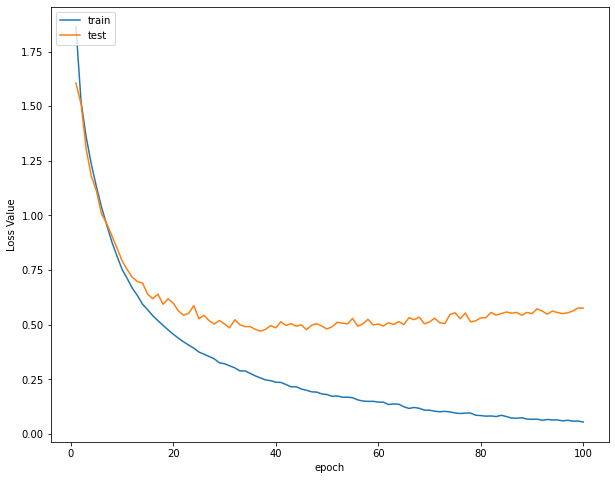

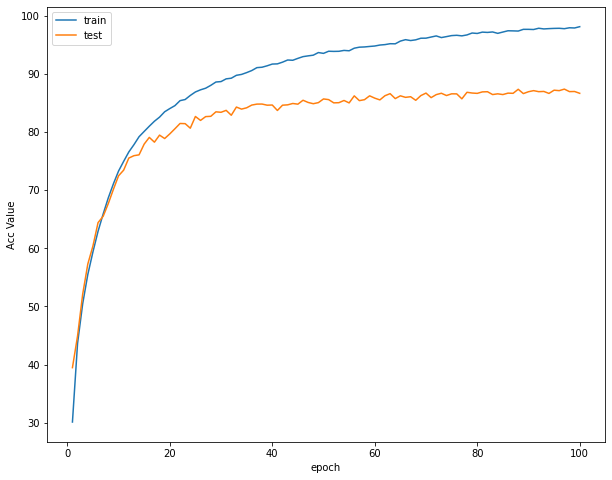

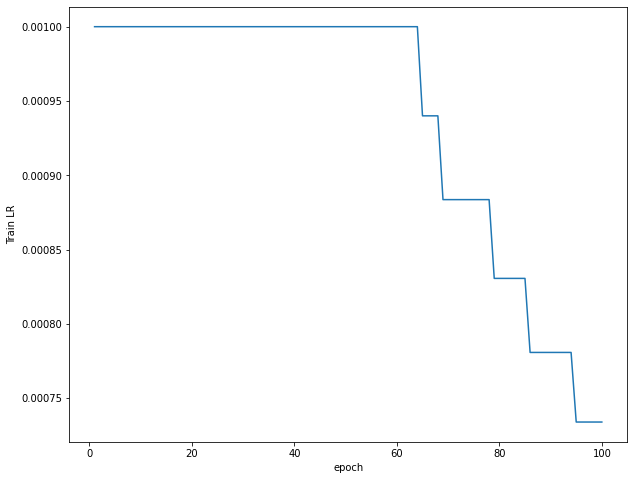

In [ ]:
plot_history(epoch ,Acc, Loss, Lr)

In [ ]:
# test images 
p_90 =0 
p_error = 0
error = 0 
correct = 0   # 定义预测正确的图片数，初始化为0
total = 0     # 总共参与测试的图片数，也初始化为0
# testloader = torch.utils.data.DataLoader(testset, batch_size=32,shuffle=True, num_workers=2)
for data in testloader:  # 循环每一个batch
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    net.eval()  # 把模型转为test模式
    if hasattr(torch.cuda, 'empty_cache'):
        torch.cuda.empty_cache()
    outputs = net(images)  # 输入网络进行测试
    prob = F.softmax(outputs,dim=1) #prob是10个分类的概率 
    # print(prob) 
    # outputs.data是一个4x10张量，将每一行的最大的那一列的值和序号各自组成一个一维张量返回，第一个是值的张量，第二个是序号的张量。
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)          # 更新测试图片的数量
    correct += (predicted == labels).sum() # 更新正确分类的图片的数量
    error += (predicted != labels).sum()
    # p_error += (predicted != labels , prob > 0.9)

    # print(error)
  
# print(predicted) 



print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))
 

Accuracy of the network on the 10000 test images: 86.84 %


In [ ]:
 # 定义2个存储每类中测试正确的个数的 列表，初始化为0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
# testloader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=True, num_workers=2)
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = net(images)
       

        _, predicted = torch.max(outputs.data, 1)
    #4组(batch_size)数据中，输出于label相同的，标记为1，否则为0
        c = (predicted == labels).squeeze()
        for i in range(len(images)):      # 因为每个batch都有4张图片，所以还需要一个4的小循环
            label = labels[i]   # 对各个类的进行各自累加
            class_correct[label] += c[i]
            class_total[label] += 1
 
 
for i in range(10):
    print('Accuracy of %5s : %.2f %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of airplane : 90.00 %
Accuracy of automobile : 95.50 %
Accuracy of  bird : 82.30 %
Accuracy of   cat : 78.00 %
Accuracy of  deer : 84.40 %
Accuracy of   dog : 74.70 %
Accuracy of  frog : 91.50 %
Accuracy of horse : 86.60 %
Accuracy of  ship : 92.60 %
Accuracy of truck : 89.80 %


Accuracy Rate = 85.9375%


<Figure size 1800x288 with 0 Axes>

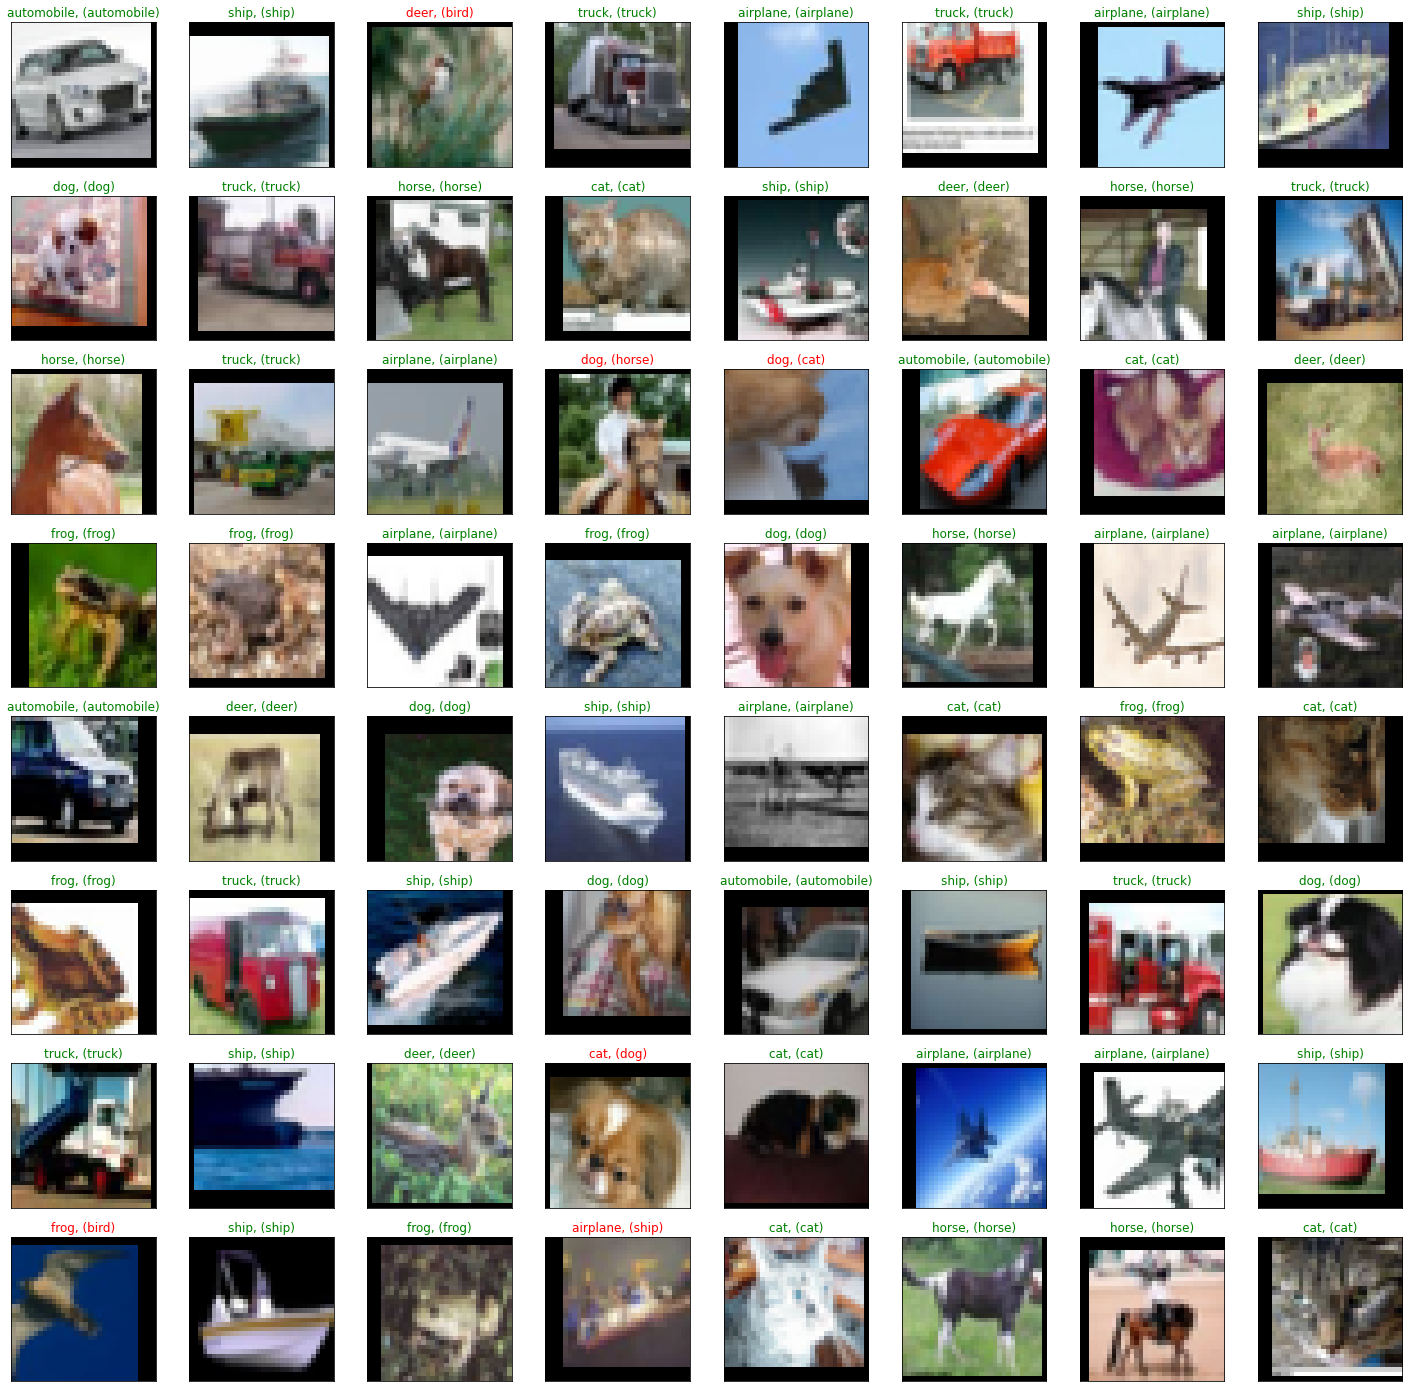

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images_ = images
#images_ = images_.view(images.shape[0], -1)
images_ = images_.to(device)
labels = labels.to(device)
val_output = net(images_)
_, val_preds = torch.max(val_output, 1)

fig = plt.figure(figsize=(25,4))

correct = torch.sum(val_preds == labels.data).item()

val_preds = val_preds.cpu()
labels = labels.cpu()

print("Accuracy Rate = {}%".format(correct/len(images) * 100))

fig = plt.figure(figsize=(25,25))
for idx in np.arange(64):    
    ax = fig.add_subplot(8, 8, idx+1, xticks=[], yticks=[])
    #fig.tight_layout()
#     plt.imshow(im_convert(images[idx]))
    imshow(images[idx])
    ax.set_title("{}, ({})".format(classes[val_preds[idx].item()], classes[labels[idx].item()]), 
                 color = ("green" if val_preds[idx].item()==labels[idx].item() else "red"))

In [ ]:
#save model

torch.save(net,save_path[:-4]+'_'+str(epoch)+'.pth')
# torch.save(net, './model/ResNet34.pth')

In [ ]:
#预测 forecast 



import torch
from PIL import Image
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
 
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MobileNetV1(num_classes=10)

model = torch.load(save_path)  # 加载模型
# model = model.to('cuda')
model.eval()  # 把模型转为test模式

# 读取要预测的图片
img = Image.open("./airplane.jpg").convert('RGB') # 读取图像

In [ ]:
trans = transforms.Compose([transforms.Resize((32,32)),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=(0.5, 0.5, 0.5), 
                                                 std=(0.5, 0.5, 0.5)),
                           ])
 
img = trans(img)
img = img.to(device)
# 图片扩展多一维,因为输入到保存的模型中是4维的[batch_size,通道,长，宽]，而普通图片只有三维，[通道,长，宽]
img = img.unsqueeze(0)  
    # 扩展后，为[1，1，28，28]
output = model(img)
prob = F.softmax(output,dim=1) #prob是10个分类的概率
print("概率",prob)
value, predicted = torch.max(output.data, 1)
print("类别",predicted.item())
print(value)
pred_class = classes[predicted.item()]
print("分类",pred_class)

概率 tensor([[1.0000e+00, 5.5220e-09, 5.0464e-09, 5.3177e-13, 3.5016e-10, 1.0557e-11,
         1.6961e-11, 2.8681e-11, 1.0269e-08, 1.7019e-08]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
类别 0
tensor([9.1522], device='cuda:0')
分类 plane


<Response [200]>


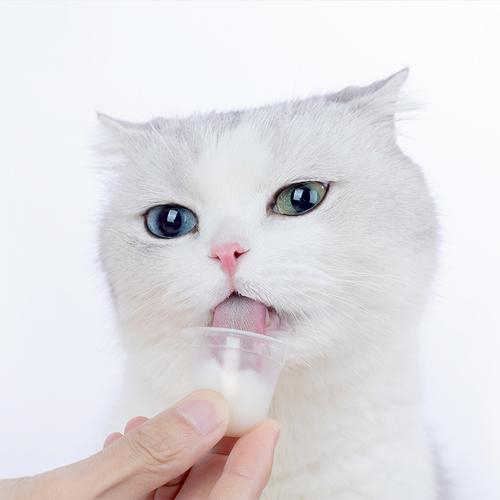

In [ ]:
import requests
from PIL import Image
url = 'https://dss2.bdstatic.com/70cFvnSh_Q1YnxGkpoWK1HF6hhy/it/u=947072664,3925280208&fm=26&gp=0.jpg'
url = 'https://ss0.bdstatic.com/70cFuHSh_Q1YnxGkpoWK1HF6hhy/it/u=2952045457,215279295&fm=26&gp=0.jpg'
url = 'https://ss0.bdstatic.com/70cFvHSh_Q1YnxGkpoWK1HF6hhy/it/u=2838383012,1815030248&fm=26&gp=0.jpg'
url = 'https://gimg2.baidu.com/image_search/src=http%3A%2F%2Fwww.goupuzi.com%2Fnewatt%2FMon_1809%2F1_179223_7463b117c8a2c76.jpg&refer=http%3A%2F%2Fwww.goupuzi.com&app=2002&size=f9999,10000&q=a80&n=0&g=0n&fmt=jpeg?sec=1624346733&t=36ba18326a1e010737f530976201326d'
url = 'https://ss3.bdstatic.com/70cFv8Sh_Q1YnxGkpoWK1HF6hhy/it/u=2799543344,3604342295&fm=224&gp=0.jpg'
# url = 'https://ss1.bdstatic.com/70cFuXSh_Q1YnxGkpoWK1HF6hhy/it/u=2032505694,2851387785&fm=26&gp=0.jpg'
response = requests.get(url, stream=True)
print (response)
img = Image.open(response.raw)
img

In [ ]:
trans = transforms.Compose([transforms.Resize((32,32)),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=(0.5, 0.5, 0.5), 
                                                 std=(0.5, 0.5, 0.5)),
                           ])
 
img = trans(img)
img = img.to(device)
# 图片扩展多一维,因为输入到保存的模型中是4维的[batch_size,通道,长，宽]，而普通图片只有三维，[通道,长，宽]
img = img.unsqueeze(0)  
    # 扩展后，为[1，1，28，28]
output = model(img)
prob = F.softmax(output,dim=1) #prob是10个分类的概率
print("概率",prob)
value, predicted = torch.max(output.data, 1)
print("类别",predicted.item())

print(value)
pred_class = classes[predicted.item()]
print("分类",pred_class)

概率 tensor([[2.4542e-05, 1.4307e-08, 1.0744e-04, 9.8746e-01, 1.6729e-06, 1.2396e-02,
         9.9519e-08, 2.8951e-06, 1.3205e-06, 1.4727e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
类别 3
tensor([4.9117], device='cuda:0')
分类 cat
